# Import Libraries

In [ ]:
#!pip install pyclustering
#!pip install openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 33.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395099 sha256=373cf4c8fb2d3565092f05c3c21036317f13eec1a9a9611fe7d1b4d744f74f71
  Stored in directory: /root/.cache/pip/wheels/9f/99/15/e881f46a92690ae77c2e3b255b89ea45d3a867b1b6c2ab3ba9
Successfully built pyclustering


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Review Data

In [ ]:
# Load dataset
raw_online_retail = pd.read_csv('/content/drive/MyDrive/online_retail.csv', low_memory=False,skiprows=1)
raw_online_retail.shape

(541909, 8)

# Cleand and Preprocess Data

In [ ]:
# Check duplicated rows
len(raw_online_retail[raw_online_retail.duplicated])

# Delete duplicate rows
online_retail_2_miss=raw_online_retail.drop_duplicates(keep='last',inplace=False)
online_retail_2_miss.shape

(536641, 8)

In [ ]:
# Check for missing values
print(online_retail_2_miss.isna().values.any())
print(online_retail_2_miss.isnull().values.any())
online_retail_2_miss.info()

True
True
<class 'pandas.core.frame.DataFrame'>
Index: 536641 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    536641 non-null  object 
 1   StockCode    536641 non-null  object 
 2   Description  535187 non-null  object 
 3   Quantity     536641 non-null  int64  
 4   InvoiceDate  536641 non-null  object 
 5   UnitPrice    536641 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      536641 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 36.8+ MB


In [ ]:
# Check missing values percetage
n_missing_description=online_retail_2_miss['Description'].isnull().sum()
n_rows, n_cols = online_retail_2_miss.shape
print('Missing fields in Description column:',round((n_missing_description*100)/n_rows,2),'%')

Missing fields in Description column: 0.27 %


In [ ]:
n_missing_customer=online_retail_2_miss['CustomerID'].isnull().sum()
print('Missing fields in CustomerID column:',round((n_missing_customer*100)/n_rows,2),'%')


Missing fields in CustomerID column: 25.16 %


In [ ]:
# Handle missing values CustomerID
online_retail_1_miss = online_retail_2_miss.dropna(subset=['CustomerID'],inplace=False)


In [ ]:
# Handle missing values
online_retail_noise = online_retail_1_miss.dropna(subset=['Description'],inplace=False)


In [ ]:
# Dropping not valuable columns
online_retail = online_retail_noise.drop(['InvoiceNo','StockCode','Description'],axis=1,inplace=False)


In [ ]:
online_retail.shape

(401604, 5)

In [ ]:
online_retail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Quantity     401604 non-null  int64  
 1   InvoiceDate  401604 non-null  object 
 2   UnitPrice    401604 non-null  float64
 3   CustomerID   401604 non-null  float64
 4   Country      401604 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 18.4+ MB


In [ ]:
# Separate InvoiceDate

online_retail['InvoiceDate'] = pd.to_datetime(online_retail['InvoiceDate'], format='%m/%d/%y %H:%M')
# Extract Date and Time separately
online_retail['Invoice_Date'] = online_retail['InvoiceDate'].dt.date      # Extract Date
online_retail['Invoice_Time'] = online_retail['InvoiceDate'].dt.time      # Extract Time
online_retail.head(2)
online_retail_sep=online_retail.drop(['InvoiceDate'],axis=1,inplace=False)


In [ ]:
online_retail_sep['Country'] = online_retail_sep['Country'].astype(str)

In [ ]:
online_retail_sep.head()

,Quantity,UnitPrice,CustomerID,Country,Invoice_Date,Invoice_Time
0,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00
1,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00
2,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00
3,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00
4,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00


In [ ]:
online_retail.shape

(401604, 7)

In [ ]:
# Find the latest purchase date in the dataset
online_retail_sep['Invoice_Date'] = pd.to_datetime(online_retail_sep['Invoice_Date'], format='%m/%d/%y')
latest_date = online_retail_sep['Invoice_Date'].max()

# Compute Recency: Days since last purchase
recency_df = online_retail_sep.groupby('CustomerID').agg({'Invoice_Date': 'max'}).reset_index()
recency_df['Recency'] = (latest_date - recency_df['Invoice_Date']).dt.days
recency_df.drop(columns=['Invoice_Date'], inplace=True)  # Remove InvoiceDate column

In [ ]:
recency_df.shape

(4372, 2)

In [ ]:
# Compute total spend per transaction
online_retail_sep['Total_Spend'] = online_retail_sep['Quantity'] * online_retail_sep['UnitPrice']

# Create customer_df with other attributes
customer_df = online_retail_sep.groupby('CustomerID').agg({
    'Quantity': 'sum',         # Total quantity bought
    'Total_Spend': 'sum',      # Total money spent
    'Country': 'first'         # Keep customer's country
}).reset_index()

# Merge Recency into customer_df
customer_df = customer_df.merge(recency_df, on='CustomerID', how='left')
customer_df.head()

,CustomerID,Quantity,Total_Spend,Country,Recency
0,12346.0,0,0.00,United Kingdom,325
1,12347.0,2458,4310.00,Iceland,2
2,12348.0,2341,1797.24,Finland,75
3,12349.0,631,1757.55,Italy,18
4,12350.0,197,334.40,Norway,310


In [ ]:
customer_df.shape

(4372, 5)

In [ ]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CustomerID   4372 non-null   float64
 1   Quantity     4372 non-null   int64  
 2   Total_Spend  4372 non-null   float64
 3   Country      4372 non-null   object 
 4   Recency      4372 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 170.9+ KB


In [ ]:
# Encoding
customer_df.drop('CustomerID',axis=1,inplace=True)

In [ ]:
customer_df.head(2)

,Quantity,Total_Spend,Country,Recency
0,0,0.0,United Kingdom,325
1,2458,4310.0,Iceland,2


In [ ]:
customer_df.shape

(4372, 4)

In [ ]:
# Encoding
customer_df_encoded = pd.get_dummies(customer_df, columns=['Country'], drop_first=True).astype(int)
customer_df_encoded.head()

,Quantity,Total_Spend,Recency,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,Country_Channel Islands,Country_Cyprus,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,0,0,325,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2458,4310,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2341,1797,75,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,631,1757,18,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,197,334,310,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# check on normal distribution
def isNormalDistributed(df,column):
    # Perform the Shapiro-Wilk test
    stat, p = shapiro(df[column])
    #print('Statistics=%.3f, p=%.3f' % (stat, p))
    # Interpretation of result
    if p > 0.05:
        print("Data is normally distributed")
    else:
        print("Data is not normally distributed")
#Plotting a histogram and a boxplot to show outliers
def hist_boxplot(df,column):
    # Generate sample continuous data
    data = df[column]

    # Create a figure with a shared axis for the histogram and box plot
    fig, ax = plt.subplots(2, 1, figsize=(4, 3), gridspec_kw={'height_ratios': [1, 4]})

    # Box plot (at the top)
    sns.boxplot(x=data, ax=ax[0], orient='h', color='skyblue')
    ax[0].set(xlabel='')

    # Histogram (at the bottom)
    ax[1].hist(data, bins=30, color='skyblue', edgecolor='black',density=True)
    ax[1].set_xlabel('Values')
    ax[1].set_ylabel('Density')

    # Title
    plt.suptitle('Fig 1. Boxplot and Histogram Column '+str(column))
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Data is not normally distributed


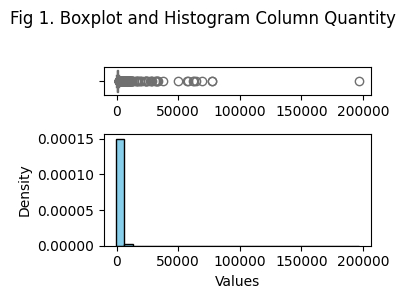

Data is not normally distributed


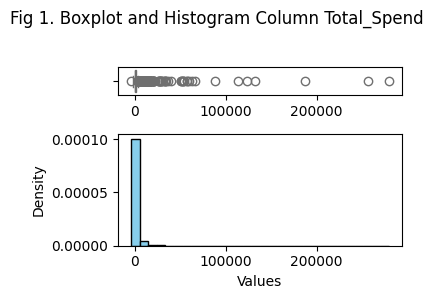

Data is not normally distributed


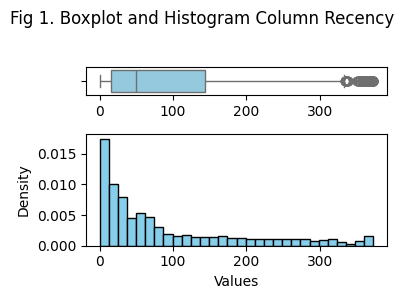

In [ ]:
from scipy.stats import shapiro #determining distributions
for c in ['Quantity','Total_Spend','Recency']:
    isNormalDistributed(customer_df,c)
    hist_boxplot(customer_df,c)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
customer_df_encoded[['Quantity', 'Total_Spend','Recency']] = scaler.fit_transform(customer_df_encoded[['Quantity', 'Total_Spend','Recency']])
customer_df_scaled = customer_df_encoded.copy()
customer_df_scaled.shape

(4372, 39)

# Reduce Dimension

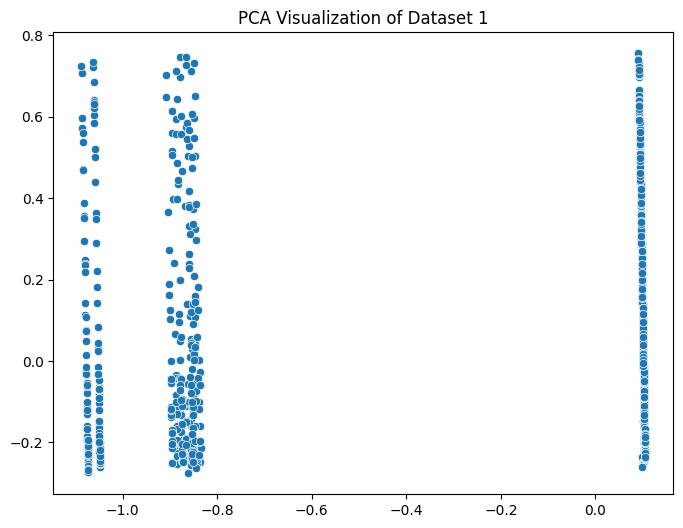

In [ ]:
#Dimensionality Reduction using PCA
pca = PCA(n_components=2)
df1_pca = pca.fit_transform(customer_df_scaled)

# Visualize Dataset_1 PCA Results
plt.figure(figsize=(8,6))
sns.scatterplot(x=df1_pca[:, 0], y=df1_pca[:, 1])
plt.title("PCA Visualization of Dataset 1")
plt.show()

# Implement Clustering Technique

In [ ]:
from pyclustering.cluster.clique import clique

# Convert the PCA-reduced NumPy array to a DataFrame
df1_pca_df = pd.DataFrame(data=df1_pca, columns=['PCA1', 'PCA2']) #adding column labels

# Convert the PCA-reduced DataFrame into a list of lists for CLIQUE
data_pca = df1_pca.tolist()

# Initialize the CLIQUE clustering model
clique_instance = clique(data_pca, amount_intervals=12, density_threshold=8)  # Adjust parameters if needed

# Process the clustering
clique_instance.process()

# Get the clusters
clusters = clique_instance.get_clusters()
print(f"Number of clusters: {len(clusters)}")
print()

# Optionally, assign the cluster labels back to your dataframe
df1_pca_df['Cluster'] = -1  # Set default cluster value to -1
for idx, cluster in enumerate(clusters):
    for point_index in cluster:
        df1_pca_df.loc[point_index, 'Cluster'] = idx  # Assign cluster label to the point

print(df1_pca_df.head())

Number of clusters: 3

       PCA1      PCA2  Cluster
0  0.092939  0.627012        1
1 -0.836580 -0.248168        0
2 -0.861484 -0.055633        0
3 -0.865639 -0.200391        0
4 -0.866168  0.575749        2


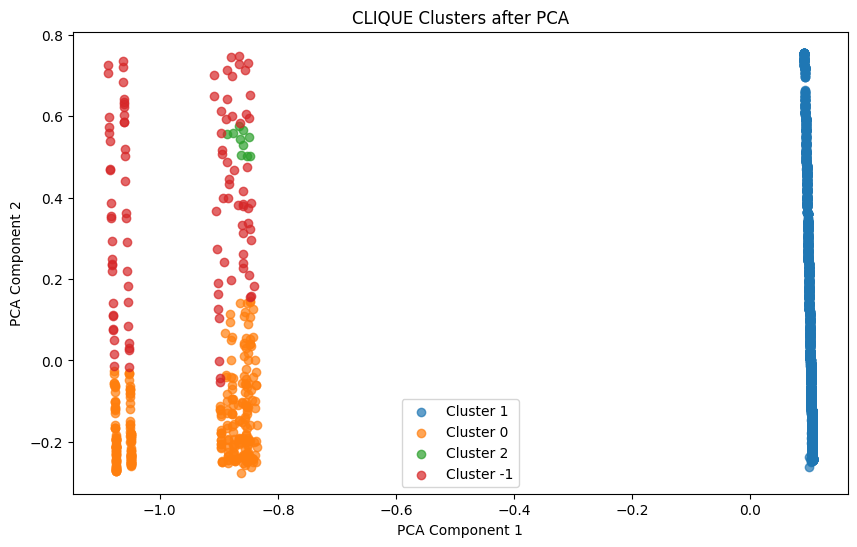

In [ ]:
import matplotlib.pyplot as plt

# We will plot the PCA components (Component 1 and Component 2) for each data point
# and color them according to their assigned cluster.

# Scatter plot for the clusters
plt.figure(figsize=(10, 6))

# Plot each cluster with a different color
for cluster_id in df1_pca_df['Cluster'].unique():
    cluster_data = df1_pca_df[df1_pca_df['Cluster'] == cluster_id]
    plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], label=f"Cluster {cluster_id}", alpha=0.7)

# Add labels and title
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("CLIQUE Clusters after PCA")
plt.legend()

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Ensure that the cluster assignments are in a format suitable for these metrics
labels = df1_pca_df['Cluster'].values

# Silhouette Score (higher is better)
sil_score = silhouette_score(df1_pca_df[['PCA1', 'PCA2']], labels)
print(f"Silhouette Score: {sil_score}")

# Davies-Bouldin Index (lower is better)
db_index = davies_bouldin_score(df1_pca_df[['PCA1', 'PCA2']], labels)
print(f"Davies-Bouldin Index: {db_index}")

# Calinski-Harabasz Index (higher is better)
ch_index = calinski_harabasz_score(df1_pca_df[['PCA1', 'PCA2']], labels)
print(f"Calinski-Harabasz Index: {ch_index}")


Silhouette Score: 0.7012935350485504
Davies-Bouldin Index: 0.954665424371534
Calinski-Harabasz Index: 2198.6809461043613
